# **Tutorial** : Which cartographic representation for a point data set ? 
## Overview of some existing techniques using CartAGen
Press **`space bar`** to show next slide 

- 🙋 **For whom ?** : 
    - people who have spatial datas to valorize through maps, but don't know how which cartographic representation to choose
    - expert cartographers who would like to discover **cartographic generalization possibilities** offered by the CartAGen tool
    - anyone who wants to learn what are the different issues when making maps from point data set (and how to assess those issues) 

Press **`space bar`** to show next message


- ❓ **What is CartAGen ?** :
    - an **open source Python library** made by **IGN** (i.e the french national mapping agency) researchers
    - a tool to carry out cartographic generalization processes and **automate** them
    - a **QGIS plugin** to use the Python library in a GIS environment  

Press **`space bar`** and **`scroll down`** to show next message 


- 📗 **How to use this Notebook ?** : 
    - a Notebook is a document that mixes **markdown cells** (i.e. cells with formatted text like this one) and **code cells**, which you can modify and execute at will
    - it comes with a **sample data set** on which you can **test** the various features of the CartAGen python library
    - you can import your **own data** and run the code cells of this Notebook, or use the CartAGen tool in **another environment** (QGIS or python script)

Press **`right arrow`** to show next slide and start part 0, or press **`space bar`** to show sub-slide and see useful links

   
- 🔗 **Useful links** : 
    - [Github repository](https://github.com/LostInZoom/cartagen4py?tab=readme-ov-file) 
    - [CartAGen documentation](https://cartagen4py.readthedocs.io/en/latest/index.html)

_by Paul Bourcier, 2024 - CC-BY-SA 4.0_

Press **`space bar`** to show next slide, press **`shift + space bar`** to go backward\
**`Click`** question mark icon to show other shortcuts

## ⚙️ **Part 0 :** Preparing the working environment

Press **`space bar`** to show code cell, then press **`shift + enter`** to execute it\
**`*`** symbol means code output is loading

In [15]:
# Importing libraries

from matplotlib import pyplot as plt # for ploting results, especially maps
import cartagen as cg # the main library, containing cartographic generalization algorithms
import geopandas as gp # used to import and manipulate geographic data
import pandas as pd # used to concatenate datas
import ipywidgets # creation of interactive plots
import os # navigation within the environnement
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar # adding scalebar to the maps
import matplotlib.colors as matcol # generating color palettes
from matplotlib.path import Path  # Plot generation
from matplotlib.patches import PathPatch # Plot generation
from matplotlib.figure import Figure # Plot generation
from mpl_toolkits.axisartist.axislines import Subplot # Plot generation
from shapely.geometry import Polygon, MultiPolygon, Point # Create and manipulate geometries
from shapely.wkt import loads # Create and manipulate geometries
from shapely import intersects
from shapely.ops import linemerge
from tqdm.notebook import tqdm # Creating loading bar
from time import sleep # Creating loading bar
import numpy as np # Using mathematical operations in Python
import re # regex
from IPython.display import clear_output, Image # used to delete widgets
import pydeck as pdk #pydeck for interactive maps
import json #manipulating dictionnaries
import contextily as ctx # Adding basemaps
import random #generating random numbers
import matplotlib.colors as mcolors #generating colors 
import matplotlib.cm as cm #used to display colorbar
# from matplotlib.path import Path
# from matplotlib.patches import PathPatch
import progressbar

import warnings # Remove warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*GeoDataFrame you are attempting to plot is empty.*") # Remove user warning 
warnings.filterwarnings("ignore", category=UserWarning, message=".*CRS not set for some of the concatenation inputs.*.")
#warnings.filterwarnings("ignore", category=SettingWithCopyWarning, message=".*A value is trying to be set on a copy of a slice from a DataFrame.*.")

## ❌ **Part 1 :** Common issues with point data representation

Nowadays, more and more spatial data set shared by data producers take form of point data set, i.e datas associated with x/y coordinate enabling their integration in maps. Those point data sets concern a wide variety of thematic : environnement, population, urbanism, mobilities, etc. 

Let's figure out some issues when cartographying these kind of data.

### **1.1/** Why displaying raw point data set can induce limitations ?

When creating maps with the purpose of showing the spatial distribution of a phenomenon, displaying every individual point of our dataset can be problematic. Let's take the example of the crepe restaurant in Brittany, France : 

**1.1.1/** Displaying maps of crepe restaurants in Brittany

In [21]:
#Displaying maps of crepe restaurants in Brittany
brittany = gp.read_file('data/puntos/brittany.geojson')
crepes = gp.read_file('data/puntos/crepes.geojson')
widgets = [
    '', progressbar.Percentage(), ' ',  
    progressbar.Bar(marker='🟩', left='', right='                                                  ', width = 1) 
]

def plt_bre_1(figure_size):
    
    with progressbar.ProgressBar(max_value=2,widgets=widgets) as bar:
        ax = brittany.plot(facecolor = 'None', edgecolor = "grey", linewidth = 0.5, figsize = (figure_size,figure_size))
        bar.update(1)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        scalebar = AnchoredSizeBar(ax.transData,
                                10000,  
                                '10 km',  
                                'lower left',  
                                pad=0.5,
                                color='black',
                                frameon=True,
                                size_vertical=1)
        ax.add_artist(scalebar)

        crepes.plot(ax=ax)    
        bar.update(2)
    
ipywidgets.interact(plt_bre_1, figure_size = ipywidgets.IntSlider(value =12, min = 1, max = 16,step = 1,continuous_update=False))

interactive(children=(IntSlider(value=12, continuous_update=False, description='figure_size', max=16, min=1), …

<function __main__.plt_bre_1(figure_size)>

💬 This map shows all the crepes restaurant in Brittany that are represented in the [OSM](https://www.openstreetmap.org/#map=14/48.81620/-1.17910) database. Because some points are overlaping eachother, it is difficult to read the spatial distribution of these restaurants. Eventhough we understand that there are more restaurants in the mains cities and in some part of the coast, we can't really say if there are more restaurants in Rennes or Brest, for example. 

💬 Let's try to lower the opacity of the points, so we can see more easily when several points are overlaping 

**1.1.2/** Displaying crepe restaurants with opacity

In [22]:
#Trying to lower the opacity to see if spatial distribution are more readable

def plt_bre_1(figure_size, opacity):
    with progressbar.ProgressBar(max_value=2,widgets=widgets) as bar:
        ax = brittany.plot(facecolor = 'None', edgecolor = "grey", linewidth = 0.5, figsize = (figure_size,figure_size))
        bar.update(1)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

        scalebar = AnchoredSizeBar(ax.transData,
                                10000,  
                                '10 km',  
                                'lower left',  
                                pad=0.5,
                                color='black',
                                frameon=True,
                                size_vertical=1)
        ax.add_artist(scalebar)

        crepes.plot(ax=ax, alpha = opacity)
        bar.update(2)
ipywidgets.interact(plt_bre_1, figure_size = ipywidgets.IntSlider(value =12, min = 1, max = 16,step = 1,continuous_update=False),
                               opacity = ipywidgets.FloatSlider(value =0.7, min = 0, max = 1,step = 0.01,continuous_update=False))



interactive(children=(IntSlider(value=12, continuous_update=False, description='figure_size', max=16, min=1), …

<function __main__.plt_bre_1(figure_size, opacity)>

With this technique, spatial distribution is getting clearer. But it is still not enough to determine in which city there is more crepes restaurants ! We will see some techniques to improve the readibility of the map regarding the spatial distribution of those restaurants in part 2... 

### **1.2/** Point data sets in multi-scale maps : the persistant problem of scale

Nowadays, geographic data sets are often displayed on interactive maps, i.e maps in which the user can change the current view by zooming or panning. When it comes to point data sets, it is true that this medium offers the possibility to look precisly where the points are located within a desired zone. However, displaying raw data point still generate map readability problems at certain scales.

Let's take the example of parking meters in Paris :

**1.2.1/** Interactive map of parking meters in Paris

In [2]:
horo = gp.read_file('data/puntos/horodateurs-mobiliers.geojson')

for i in range(len(horo)):
    horo.loc[i,'lon'] = json.loads(horo.loc[i,'geo_point_2d'])['lon']
    horo.loc[i,'lat'] = json.loads(horo.loc[i,'geo_point_2d'])['lat']

mean_latitude = horo.lat.mean()
mean_longitude = horo.lon.mean()
df = horo.drop(columns='geometry')

layer = pdk.Layer(
    "ScatterplotLayer",
    df,
    opacity=0.8,
    stroked=True,
    filled=True,
    radius_scale=6,
    radius_min_pixels=5,
    radius_max_pixels=100,
    line_width_min_pixels=0,
    get_position=["lon", "lat"],
    pickable=True,
)

view_state = pdk.ViewState(longitude=mean_longitude, latitude=mean_latitude, zoom=15, bearing=0, pitch=0)

r = pdk.Deck(layers=[layer],initial_view_state=view_state, map_provider="carto",  map_style="light_no_labels", tooltip={"text": "{numhoro}"})

r.to_html('ScatterplotLayer.html')

This example highlights one fact : when the zoom level is high, displaying every point of our data set is a good idea since we easily understand where is each parking meters (which can be useful to find one in a real context). However, when the zoom level is low (for example when it is possible to see Paris as a whole), the map is saturated of information, raw point representation not being optimized in that case.

In fact, the problem the problem of showing all points at low zoom levels is not only that map is saturated with points, but also that map reader needs most likely change. Indeed, when looking at whole Paris, the need of the map reader is probably not to find the parking meters next to him, but most likely to understand how this equipment is distributed in the city (without understanding the precise location of each of them).

To conclude on this part, interactive maps don't solve the problem of cartographic representation of the datas. In other words, there are still needs for transforming it at certain scales, to make the map more readable. Those transforming operations are called cartographic generalization. CartAGen proposes some tools to perform generalization.

## 🛠 **Part 2 :** Exploring cartographic generalization techniques with CartAGen
As we saw, scale is what matter when defining which cartographic representation to choose. Let's explore generalization techniques according to it.

### **2.1/** Point displacement techniques
At large scale (i.e small zones, high zoom level...), we generally want to keep each point in our representation, to be as close as reality. When points start to overlap eachother, point displacement algorithms can be useful, since they make the map more readable but also keep the number of points on the map.

**2.1.1/** Display the points to displace

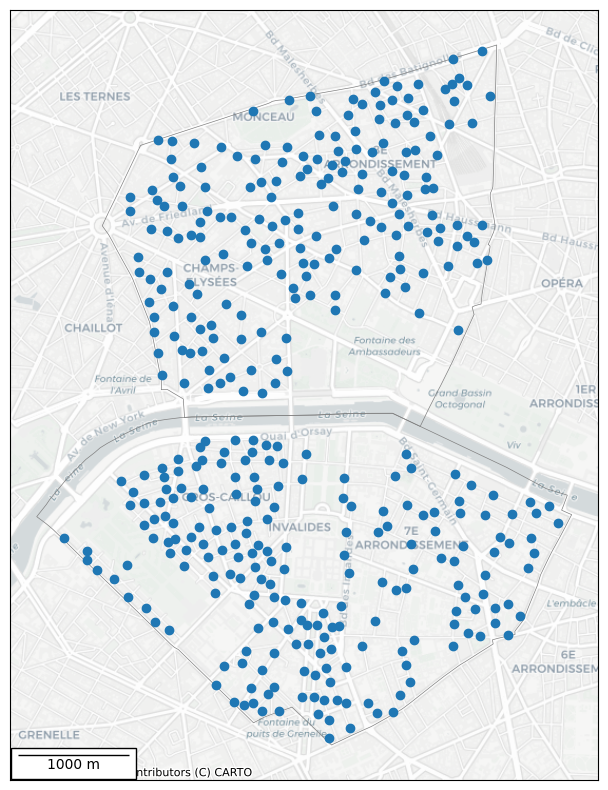

In [21]:
# Display points to displace
admin = gp.read_file('data/puntos/arr_paris.geojson')
admin.to_crs(crs="EPSG:3857",inplace=True)
horo.to_crs(crs="EPSG:3857",inplace=True)
horo_ok = gp.clip(horo, admin.loc[14:15])


ax = admin.loc[14:15].plot(facecolor = 'None', edgecolor = "grey", linewidth = 0.5, figsize = (10,10))
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
scalebar = AnchoredSizeBar(ax.transData,
                        1000,  
                        '1000 m',  
                        'lower left',  
                        pad=0.5,
                        color='black',
                        frameon=True,
                        size_vertical=1)
ax.add_artist(scalebar)

horo_ok.plot(ax=ax)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)


Yet, there is no algorithm dedicated to point displacement in CartAGen. Nonetheless, it is possible to use the random_displacement algorithm by transforming our points into polygons before : 

**2.1.2/** Converting points to polygons by creating buffers

In [14]:
# Converting points to polygons by creating buffers
horo_poly = horo_ok.copy()
horo_poly.geometry = horo_poly.geometry.buffer(42)

if horo_poly.geometry.geom_type.unique()[0] == 'Polygon':
    print("✅ successful transformation")
else:
    print("❌ transformation failed")

✅ successful transformation


**2.1.3/** Displacing points using the random_displacement algorithm

In [ ]:
# Displacing point buffers

def disp_pts(figure_size, polygon_distance, max_trials, max_displacement):
    global horo_poly
    pbar = tqdm(range(4), total = 4, desc = "displacing points : ")
    horo_poly = cg.random_displacement(horo_poly, polygon_distance=polygon_distance, max_trials=max_trials, max_displacement=max_displacement)
    pbar.update(1.0)
    horo_ok = gp.clip(horo, admin.loc[14:15])
    pbar.update(1.0)

    fig, axs = plt.subplots(1, 2, figsize = (figure_size,figure_size))

    axs[0].set_title('Before', pad=10, family='sans-serif')
    axs[0].scatter(np.asarray(horo_ok.geometry.get_coordinates())[:,:1], np.asarray(horo_ok.geometry.get_coordinates())[:,-1])
    pbar.update(1.0)
    axs[0].autoscale_view()
    ctx.add_basemap(axs[0],source=ctx.providers.CartoDB.Positron)
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)

    axs[1].set_title('After', pad=10, family='sans-serif')
    axs[1].scatter(np.asarray(horo_poly.geometry.centroid.get_coordinates())[:,:1], np.asarray(horo_poly.geometry.centroid.get_coordinates())[:,-1])
    pbar.update(1.0)
    axs[1].autoscale_view()
    ctx.add_basemap(axs[1],source=ctx.providers.CartoDB.Positron)
    fig.axes[1].get_xaxis().set_visible(False)
    fig.axes[1].get_yaxis().set_visible(False)
    #plt.show()
    pbar.close()

ipywidgets.interact(disp_pts, figure_size = ipywidgets.IntSlider(value =16, min = 1, max = 16,step = 1,continuous_update=False),
                              polygon_distance = ipywidgets.BoundedIntText(value=10, min=0, max=200, step=1,description='polygon distance'),
                              max_trials = ipywidgets.BoundedIntText(value=10, min=0, max=200, step=1,description='max trials'),
                              max_displacement = ipywidgets.BoundedIntText(value=10, min=0, max=200, step=1,description='max displacement'))

**2.1.3'/** Code details on random_displacement algorithm

In [ ]:
qsqdqsd

### **2.2/** Point reduction techniques
As the scale decreazes, more and more points overlaps eachother, so that displacement become less easy to perform. At this point, having all the points on the map become less important : the map is more about having a global vision of the spatial distribution of the datas. Point reductions algorithms enable these transformations.

**2.2.1/** Using reduce_points_kmeans algorithm

In [19]:
# Reduce_points_kmeans algorithm
horo_ok = gp.clip(horo, admin.loc[13:16])

def kmean(figure_size, shrink_ratio, centroid):
    fig, axs = plt.subplots(1, 2, figsize = (figure_size,figure_size))

    horo_red = cg.reduce_points_kmeans(list(horo_ok.geometry),shrink_ratio=shrink_ratio,centroid=centroid)

    axs[0].set_title('Before', pad=10, family='sans-serif')
    axs[0].scatter(x=np.asarray(horo_ok.geometry.get_coordinates())[:,:1], y= np.asarray(horo_ok.geometry.get_coordinates())[:,-1])
    ctx.add_basemap(axs[0],source=ctx.providers.CartoDB.Positron)
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)

    axs[1].set_title('After', pad=10, family='sans-serif')
    axs[1].scatter(np.asarray([(point.x, point.y) for point in horo_red])[:,:1], np.asarray([(point.x, point.y) for point in horo_red])[:,-1])
    ctx.add_basemap(axs[1],source=ctx.providers.CartoDB.Positron)
    fig.axes[1].get_xaxis().set_visible(False)
    fig.axes[1].get_yaxis().set_visible(False)

ipywidgets.interact(kmean, figure_size = ipywidgets.IntSlider(value =16, min = 1, max = 16,step = 1,continuous_update=False),
                           shrink_ratio = ipywidgets.FloatSlider(value =0.7, min = 0, max = 1,step = 0.01,continuous_update=False),
                           centroid = False)

interactive(children=(IntSlider(value=16, continuous_update=False, description='figure_size', max=16, min=1), …

<function __main__.kmean(figure_size, shrink_ratio, centroid)>

The reduce point kmeans algorithm tends to uniformize the spatial distribution of the point data set by deleting more points in areas where the point density is higher. It can be a problem, because there is a risk that cartographic representation doesn't reflect real spatial distribution. Here is another algorithms to reduce the number of points : 

**2.2.1'/** Code details on reduce_points_kmeans algorithm

In [ ]:
sqdsq

**2.2.2/** Using reduce_points_quadtree algorithm

In [39]:
# reduce_points_quadtree algorithm (simplification mode)
horo_ok = gp.clip(horo, admin.loc[13:16])

def qtree_simp(figure_size, depth, sizes):
    fig, axs = plt.subplots(1, 2, figsize = (figure_size,figure_size))

    # horo_red = cg.reduce_points_quadtree(horo_ok,5,mode='simplification')
    # horo_red = [x[0] for x in horo_red[0]]

    horo_red = cg.reduce_points_quadtree(horo_ok,depth=depth,mode='simplification')
    horo_red = gp.GeoDataFrame({'geometry':gp.GeoSeries([x[0] for x in horo_red[0]]),'nb_aggr':[x[2] for x in horo_red[0]]})

    axs[0].set_title('Before', pad=10, family='sans-serif')
    axs[0].scatter(x=np.asarray(horo_ok.geometry.get_coordinates())[:,:1], y= np.asarray(horo_ok.geometry.get_coordinates())[:,-1])
    ctx.add_basemap(axs[0],source=ctx.providers.CartoDB.Positron)
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)

    axs[1].set_title('After', pad=10, family='sans-serif')
    if sizes == False:
        axs[1].scatter(np.asarray(horo_red.geometry.get_coordinates())[:,:1], y= np.asarray(horo_red.geometry.get_coordinates())[:,-1])
    else: 
        axs[1].scatter(np.asarray(horo_red.geometry.get_coordinates())[:,:1], y= np.asarray(horo_red.geometry.get_coordinates())[:,-1], s= horo_red.nb_aggr*8)
    ctx.add_basemap(axs[1],source=ctx.providers.CartoDB.Positron)
    fig.axes[1].get_xaxis().set_visible(False)
    fig.axes[1].get_yaxis().set_visible(False)
    axs[1].set_xlim(left=253668, right=261883)
    axs[1].set_ylim(bottom=6248519, top=6258324)

ipywidgets.interact(qtree_simp, figure_size = ipywidgets.IntSlider(value =16, min = 1, max = 16,step = 1,continuous_update=False),
                                depth = ipywidgets.IntSlider(value =5, min = 0, max = 8,step = 1,continuous_update=False),
                                sizes = False)

interactive(children=(IntSlider(value=16, continuous_update=False, description='figure_size', max=16, min=1), …

<function __main__.qtree_simp(figure_size, depth, sizes)>

The reduce point quadtree algorithm seems quicker in terms of processing time. It also has the advantage that it is possible to change the size of the points according to the number of deleted points (making the spatial distribution easier to understand). 

It has the disavantage that the reduction strenth can not be thinly set up.

Note that those algorithms delete points based on their position, without dealing with attributes. In others words, if you want to reduce point prior to setting up a symbology based on an attribute value, you should not use those algorithms. Here what you could do. 

**2.2.2'/** Code details on reduce_points_quadtree algorithm

In [ ]:
sfsf

**2.2.3/** Adding a fake attribute to our datas

Let's say we add an attribute containing the number of places in the parking area

In [4]:
# Adding a fake value to parking meters points (let's say the number of places in the parking area)
horo_value = horo.copy()
horo_value['nb_places'] = [random.randint(1, 100) for i in range(len(horo_value))]

#create a field based on index for merging df later
horo_value['index'] = horo_value.index

horo_value[['nb_places','index','numhoro']].head(2)

nb_places  index   numhoro
0         11      0  60430102
1          6      1  74620201

**2.2.4/** Using reduce_points_quadtree algorithm with selection mode  

In [6]:
# Using the reduce_points_quadtree algorithm with selection mode 
horo_value_clp = gp.clip(horo_value, admin.loc[13:16])
extent = horo_value_clp.total_bounds

def qtree_selec(figure_size, depth, sizes):
    fig, axs = plt.subplots(1, 2, figsize = (figure_size,figure_size))

    horo_red = cg.reduce_points_quadtree(horo_value_clp,depth=depth,mode='selection',attribute='nb_places')
    horo_red = gp.GeoDataFrame({'geometry':gp.GeoSeries([x[0] for x in horo_red[0]]),'index':[x[1] for x in horo_red[0]]})
    horo_red = horo_red.merge(right=horo_value, how='left', on = 'index')
    horo_red.set_geometry(horo_red.geometry_x, inplace=True)

    axs[0].set_title('Before', pad=10, family='sans-serif')
    axs[0].scatter(x=np.asarray(horo_value_clp.geometry.get_coordinates())[:,:1], y= np.asarray(horo_value_clp.geometry.get_coordinates())[:,-1], s= horo_value_clp.nb_places)
    ctx.add_basemap(axs[0],source=ctx.providers.CartoDB.Positron)
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    plt.xlim(extent[0]-350, extent[2]+350)
    plt.ylim(extent[1]-350, extent[3]+350)	


    axs[1].set_title('After', pad=10, family='sans-serif')
    if sizes == True:
        axs[1].scatter(np.asarray(horo_red.geometry.get_coordinates())[:,:1], y= np.asarray(horo_red.geometry.get_coordinates())[:,-1], s= horo_red.nb_places)
    else:
        axs[1].scatter(np.asarray(horo_red.geometry.get_coordinates())[:,:1], y= np.asarray(horo_red.geometry.get_coordinates())[:,-1]) 
    ctx.add_basemap(axs[1],source=ctx.providers.CartoDB.Positron)
    fig.axes[1].get_xaxis().set_visible(False)
    fig.axes[1].get_yaxis().set_visible(False)
    plt.xlim(extent[0]-350, extent[2]+350)
    plt.ylim(extent[1]-350, extent[3]+350)	

ipywidgets.interact(qtree_selec, figure_size = ipywidgets.IntSlider(value =16, min = 1, max = 16,step = 1,continuous_update=False),
                                 depth = ipywidgets.IntSlider(value =5, min = 0, max = 8,step = 1,continuous_update=False),
                                 sizes = True)


interactive(children=(IntSlider(value=16, continuous_update=False, description='figure_size', max=16, min=1), …

<function __main__.qtree_selec(figure_size, depth, sizes)>

In this case, for each group of points in which the algorithm deletes points, the point with the highest value is kept. However, reduce_point_quadtree algorithm also tends to uniformize the spatial distribution

**2.2.4'/** Code details on reduce_points_quadtree algorithm with selection mode 

In [ ]:
sdqsdqs

**2.2.5/** Using reduce_points_labelgrid algorithm with selection mode 

In [7]:
# Using the LabelGrid algorithm with selection mode 
horo_value_clp = gp.clip(horo_value, admin.loc[13:16])
# rename value column to 'value'
horo_value_clp = horo_value_clp.rename(columns={"nb_places":"value"}) 

def lb_selec(figure_size, typ, width, height, sizes, show_grid):
    lg = cg.LabelGrid(horo_value_clp, width = width, height = height, typ=typ, mode='selection')
    lg.set_point_label_grid()
    res = lg.getPointResults()
    grid = lg.getGrid()

    fig, axs = plt.subplots(1, 2, figsize = (figure_size,figure_size))

    axs[0].set_title('Before', pad=10, family='sans-serif')
    axs[0].scatter(x=np.asarray(horo_value_clp.geometry.get_coordinates())[:,:1], y= np.asarray(horo_value_clp.geometry.get_coordinates())[:,-1],s= horo_value_clp.value)
    ctx.add_basemap(axs[0],source=ctx.providers.CartoDB.Positron)
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    plt.xlim(extent[0]-350, extent[2]+350)
    plt.ylim(extent[1]-350, extent[3]+350)	


    axs[1].set_title('After', pad=10, family='sans-serif')
    if sizes == True:
        axs[1].scatter(x=np.asarray(res.geometry.get_coordinates())[:,:1], y= np.asarray(res.geometry.get_coordinates())[:,-1], s=res.value)
    else:
        axs[1].scatter(x=np.asarray(res.geometry.get_coordinates())[:,:1], y= np.asarray(res.geometry.get_coordinates())[:,-1])
    if show_grid == True:
        for i in range(len(grid)):
            poly = Path.make_compound_path(Path(np.asarray(grid.geometry[i].exterior.coords)[:, :2]),*[Path(np.asarray(ring.coords)[:, :2]) for ring in grid.geometry[i].interiors])
            axs[1].add_patch(PathPatch(poly, facecolor= 'None', edgecolor='black',linewidth = 0.15))
    ctx.add_basemap(axs[1],source=ctx.providers.CartoDB.Positron)
    fig.axes[1].get_xaxis().set_visible(False)
    fig.axes[1].get_yaxis().set_visible(False)
    plt.xlim(extent[0]-350, extent[2]+350)
    plt.ylim(extent[1]-350, extent[3]+350)	

ipywidgets.interact(lb_selec, figure_size = ipywidgets.IntSlider(value =16, min = 1, max = 16,step = 1,continuous_update=False),
                              typ = ipywidgets.Dropdown(options=['square', 'diamond', 'hexagonal'], value='square', description='Cell shape:'),
                              width = ipywidgets.IntSlider(value =250, min = 0, max = 1000,step = 1,continuous_update=False),
                              height = ipywidgets.IntSlider(value =250, min = 0, max = 1000,step = 1,continuous_update=False),
                              sizes = True,
                              show_grid = False)

interactive(children=(IntSlider(value=16, continuous_update=False, description='figure_size', max=16, min=1), …

<function __main__.lb_selec(figure_size, typ, width, height, sizes, show_grid)>

The Label Grid algorithm basically do the same, but seems to preserves more the spatial distribution of the points, since the reduction strentgh is the same everywhere (witout taking in account point density)

**2.2.5'/** Code details on reduce_points_labelgrid algorithm with selection mode 

In [ ]:
sfsdf

### **2.3/** Agregation techniques
At one moment, it becomes useless to represent point data as points on map. Indeed, at smaller scales (at whole Brittany in our first example and at Paris scale in the second one), there are wether to much information to display, or to much overlaps between points. In cartography, there are several ways to tackle this problem. Agregation is one of those.

Agregation consists of "merging" the information of the points into broader spatial entities (generally a polygon). A common type of agregation is the one made with administrative (or statistical) units. Performing agregation in administrative units doesn't require to use CartAGen (only Geopandas is needed).

**2.3.1/** Perform agregation in administrative/statistical units

In [5]:
# Agregating points into adminstrative units in Paris
def multipolygon_to_polygon(geom): # function that transform MultiPolygon geometry to Polygon
    if isinstance(geom, MultiPolygon):
        return geom.geoms[0]
    return geom

mun = admin.copy()
mun.loc[:,'geometry'] = mun.loc[:,'geometry'].apply(multipolygon_to_polygon)
neigh = gp.read_file('data/puntos/quartier_paris.geojson')
neigh.to_crs(crs="EPSG:3857",inplace=True)
iris = gp.read_file('data/puntos/iris.geojson')
iris.to_crs(crs="EPSG:3857",inplace=True)
iris.loc[:,'geometry'] = iris.loc[:,'geometry'].apply(multipolygon_to_polygon) 

horo_enr = gp.sjoin(horo_value, mun)
horo_enr = horo_enr[["numhoro","nb_places","ID","NOM","geometry"]]
horo_enr = gp.sjoin(horo_enr, neigh)
horo_enr = horo_enr[["numhoro","nb_places","ID","NOM","n_sq_qu", "l_qu","geometry"]]
horo_enr = gp.sjoin(horo_enr, iris)
horo_enr = horo_enr[["numhoro","nb_places","ID","NOM","n_sq_qu", "l_qu","code_iris","nom_iris", "geometry"]]
horo_enr['nb_pm'] = 1

def agr_admin(figure_size, unit, value, show_units):
    if unit == 'IRIS':
        unit = 'code_iris'
    elif unit == 'neighborhoods':
        unit = 'n_sq_qu'
    else:
        unit = 'ID'

    if value == 'sum of places':
        value = 'nb_places'
    else:
        value = 'nb_pm'

    fig, axs = plt.subplots(1, 2, figsize = (figure_size,figure_size))

    horo_agr = horo_enr.groupby([unit]).sum(['nb_pm'])

    if unit == 'code_iris':
        unit_to_disp = iris.merge(right=horo_agr, how='left', on = 'code_iris')
    elif unit == 'n_sq_qu':
        unit_to_disp = neigh.merge(right=horo_agr, how='left', on = 'n_sq_qu')
    else:
        unit_to_disp = mun.merge(right=horo_agr, how='left', on = 'ID')

    axs[0].set_title('Before', pad=10, family='sans-serif')
    axs[0].scatter(x=np.asarray(horo.geometry.get_coordinates())[:,:1], y= np.asarray(horo.geometry.get_coordinates())[:,-1])
    ctx.add_basemap(axs[0],source=ctx.providers.CartoDB.Positron)
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    axs[0].set_aspect('equal')
    axs[0].set_xlim(left=249654, right=272000)
    axs[0].set_ylim(bottom=6243332, top=6258584)

    axs[1].set_title('After', pad=10, family='sans-serif')
    if value == 'nb_places':
        axs[1].scatter(np.asarray(unit_to_disp.geometry.centroid.get_coordinates())[:,:1], y= np.asarray(unit_to_disp.geometry.centroid.get_coordinates())[:,-1], s= unit_to_disp[value]*0.2)
    else:
        axs[1].scatter(np.asarray(unit_to_disp.geometry.centroid.get_coordinates())[:,:1], y= np.asarray(unit_to_disp.geometry.centroid.get_coordinates())[:,-1], s= unit_to_disp[value])
    if show_units == True:
        for i in range(len(unit_to_disp)):
            poly = Path.make_compound_path(Path(np.asarray(unit_to_disp.geometry[i].exterior.coords)[:, :2]),*[Path(np.asarray(ring.coords)[:, :2]) for ring in unit_to_disp.geometry[i].interiors])
            axs[1].add_patch(PathPatch(poly, facecolor= 'None', edgecolor='black',linewidth = 0.15))
    ctx.add_basemap(axs[1],source=ctx.providers.CartoDB.Positron)
    fig.axes[1].get_xaxis().set_visible(False)
    fig.axes[1].get_yaxis().set_visible(False)
    axs[1].set_aspect('equal')
    axs[1].set_xlim(left=249654, right=272000)
    axs[1].set_ylim(bottom=6243332, top=6258584)

ipywidgets.interact(agr_admin, figure_size = ipywidgets.IntSlider(value =16, min = 1, max = 16,step = 1,continuous_update=False),
                               unit = ipywidgets.Dropdown(options=['IRIS', 'neighborhoods', 'municipalities'], value='neighborhoods', description='Agregation units:',style = {'description_width': 'initial'}),
                               value = ipywidgets.Dropdown(options=['sum of places', 'count of parking meters'], value='count of parking meters', description='Values represented:',style = {'description_width': 'initial'}),
                               show_units = False)

interactive(children=(IntSlider(value=16, continuous_update=False, description='figure_size', max=16, min=1), …

<function __main__.agr_admin(figure_size, unit, value, show_units)>

Thus, you can represent datas agregated in polygonal units as circles. You can also represent directly those units, and set up their color according to the information they contain (instead of showing it through circle size). However, this require to calculates ratio indicators, since it is not recommanded to show stock values with colors.

**2.3.2/** Display agregated datas in choroplete map style

In [25]:
# Creating ratio indicators to display agregated data in choroplete map style
mun.to_crs(crs="EPSG:2154",inplace=True)
mun['area'] = mun['geometry'].area/1000000 #square kilometers

neigh.to_crs(crs="EPSG:2154",inplace=True)
neigh['area'] = neigh['geometry'].area/1000000

iris.to_crs(crs="EPSG:2154",inplace=True)
iris['area'] = iris['geometry'].area/1000000

def agr_admin_choro(figure_size, unit, value, colors):
    fig = plt.figure(1, (figure_size, figure_size))

    if value == 'sum of places':
        value = 'nb_places'
    else:
        value = 'nb_pm'

    if unit == 'IRIS':
        unit = 'code_iris'
    elif unit == 'neighborhoods':
        unit = 'n_sq_qu'
    else:
        unit = 'ID'

    horo_agr = horo_enr.groupby([unit]).sum(['nb_pm'])
    
    if unit == 'code_iris':
        unit_to_disp = iris.merge(right=horo_agr, how='left', on = 'code_iris')
    elif unit == 'n_sq_qu':
        unit_to_disp = neigh.merge(right=horo_agr, how='left', on = 'n_sq_qu')
    else:
        unit_to_disp = mun.merge(right=horo_agr, how='left', on = 'ID')

    unit_to_disp['density'] = unit_to_disp[value]/unit_to_disp['area']
    unit_to_disp = unit_to_disp.dropna()
    unit_to_disp = unit_to_disp.reset_index(drop = True)
    unit_to_disp.loc[:,'geometry'] = unit_to_disp.loc[:,'geometry'].apply(multipolygon_to_polygon) 
    unit_to_disp.to_crs(crs="EPSG:3857", inplace=True)

    sub1 = fig.add_subplot(121)
    sub1.set_title('Before', pad=10, family='sans-serif')
    sub1.scatter(x=np.asarray(horo.geometry.get_coordinates())[:,:1], y= np.asarray(horo.geometry.get_coordinates())[:,-1])
    ctx.add_basemap(sub1,source=ctx.providers.CartoDB.Positron)
    sub1.axes.get_xaxis().set_visible(False)
    sub1.axes.get_yaxis().set_visible(False)
    sub1.set_aspect('equal')
    sub1.set_xlim(left=249654, right=272000)
    sub1.set_ylim(bottom=6243332, top=6258584)

    sub2 = fig.add_subplot(122)
    sub2.set_title('After', pad=10, family='sans-serif')
    cmap = plt.get_cmap(colors)
    norm = mcolors.Normalize(vmin=unit_to_disp['density'].min(), vmax=unit_to_disp['density'].max())

    for i in range(len(unit_to_disp)):
        color_value = unit_to_disp.loc[i, 'density']/unit_to_disp.loc[:, 'density'].max()
        color = cmap(color_value)

        poly = Path.make_compound_path(Path(np.asarray(unit_to_disp.geometry[i].exterior.coords)[:, :2]),*[Path(np.asarray(ring.coords)[:, :2]) for ring in unit_to_disp.geometry[i].interiors])
        sub2.add_patch(PathPatch(poly, facecolor= color, edgecolor='black',linewidth = 0.15, alpha = 0.7))

    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array(unit_to_disp['density'])
    cbar = fig.colorbar(mappable, ax = sub2, fraction=0.03, pad=-0.025, orientation='vertical')
    cbar.set_label(f'{value} per km²')  

    sub2.axes.get_xaxis().set_visible(False)
    sub2.axes.get_yaxis().set_visible(False)
    sub2.set_aspect('equal') 
    sub2.set_xlim(left=249654, right=272000)
    sub2.set_ylim(bottom=6243332, top=6258584)
    ctx.add_basemap(sub2,source=ctx.providers.CartoDB.Positron)

ipywidgets.interact(agr_admin_choro, figure_size = ipywidgets.IntSlider(value =16, min = 1, max = 16,step = 1,continuous_update=False),
                               unit = ipywidgets.Dropdown(options=['IRIS', 'neighborhoods', 'municipalities'], value='neighborhoods', description='Agregation units:',style = {'description_width': 'initial'}),
                               value = ipywidgets.Dropdown(options=['sum of places', 'count of parking meters'], value='count of parking meters', description='Values represented:', style = {'description_width': 'initial'}),
                               colors = ipywidgets.Dropdown(options=['Reds', 'YlOrRd','viridis'], value='Reds', description='Color palette:', style = {'description_width': 'initial'}))

interactive(children=(IntSlider(value=16, continuous_update=False, description='figure_size', max=16, min=1), …

<function __main__.agr_admin_choro(figure_size, unit, value, colors)>

We can identify two main problems for this technique :
- There are not always administrative/statistical units available for the desired zone
- Sometimes there are big size differencies between units, which make the spatial distribution of the datas harder to see (which can be partially tackle by creating ratio indicators)

For those reason, it can be interesting to agregate our points into regular geographical entities, such as the cells of a grid 

**2.3.3/** Using reduce_point_labelgrid (agregation mode) to perform agregation in a grid

In [13]:
# Using the Label Grid algorithm to aggregate datas 
horo_value = horo_value.rename(columns={"nb_places":"value"}) 
extent = horo.total_bounds

def agr_grid(figure_size, width, height, typ, value, show_grid):
    lg = cg.LabelGrid(horo_value, width = width, height = height, typ=typ, mode='aggregation')
    lg.set_point_label_grid()
    grid = lg.getGrid()
    res = lg.getPointResults()

    fig, axs = plt.subplots(1, 2, figsize = (figure_size,figure_size))

    axs[0].set_title('Before', pad=10, family='sans-serif')
    axs[0].scatter(x=np.asarray(horo.geometry.get_coordinates())[:,:1], y= np.asarray(horo.geometry.get_coordinates())[:,-1])
    ctx.add_basemap(axs[0],source=ctx.providers.CartoDB.Positron)
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    plt.xlim(extent[0]-350, extent[2]+350)
    plt.ylim(extent[1]-350, extent[3]+350)	


    axs[1].set_title('After', pad=10, family='sans-serif')
    if value == 'count of parking meters':
        axs[1].scatter(x=np.asarray(res.geometry.get_coordinates())[:,:1], y= np.asarray(res.geometry.get_coordinates())[:,-1], s=res['point_count']*2.5)
    else:
        axs[1].scatter(x=np.asarray(res.geometry.get_coordinates())[:,:1], y= np.asarray(res.geometry.get_coordinates())[:,-1], s=res['sum_value']*0.15)
    if show_grid == True:
        for i in range(len(grid)):
            poly = Path.make_compound_path(Path(np.asarray(grid.geometry[i].exterior.coords)[:, :2]),*[Path(np.asarray(ring.coords)[:, :2]) for ring in grid.geometry[i].interiors])
            axs[1].add_patch(PathPatch(poly, facecolor= 'None', edgecolor='black',linewidth = 0.15))

    ctx.add_basemap(axs[1],source=ctx.providers.CartoDB.Positron)
    fig.axes[1].get_xaxis().set_visible(False)
    fig.axes[1].get_yaxis().set_visible(False)
    plt.xlim(extent[0]-350, extent[2]+350)
    plt.ylim(extent[1]-350, extent[3]+350)	

ipywidgets.interact(agr_grid, figure_size = ipywidgets.IntSlider(value =16, min = 1, max = 20,step = 1,continuous_update=False),
                              typ = ipywidgets.Dropdown(options=['square', 'diamond', 'hexagonal'], value='square', description='Cell shape:'),
                              width = ipywidgets.IntSlider(value =500, min = 0, max = 1000,step = 1,continuous_update=False),
                              height = ipywidgets.IntSlider(value =500, min = 0, max = 1000,step = 1,continuous_update=False),
                              value = ipywidgets.Dropdown(options=['sum of places', 'count of parking meters'], value='count of parking meters', description='Values represented:', style = {'description_width': 'initial'}),
                              show_grid = False)

interactive(children=(IntSlider(value=16, continuous_update=False, description='figure_size', max=20, min=1), …

<function __main__.agr_grid(figure_size, width, height, typ, value, show_grid)>

Just like with administrative units, you can display the data in the form of colorized grid cells. Since each cell has the same size, it is possible to display the data without calculating a ratio indicator.

**2.3.3'/** Code details on reduce_point_labelgrid (agregation mode) algorithm

**2.3.4/** Display the agregation grid from reduce_point_labelgrid

In [17]:
# Display the grid from Label Grid agregation 
extent = horo.total_bounds

def agr_grid_choro(figure_size, value, width, height, typ, colors):
    lg = cg.LabelGrid(horo_value, width = width, height = height, typ=typ, mode="aggregation")
    lg.set_point_label_grid()
    res = lg.getGridResults()

    fig, axs = plt.subplots(1, 2, figsize = (figure_size,figure_size))

    axs[0].set_title('Before', pad=10, family='sans-serif')
    axs[0].scatter(x=np.asarray(horo.geometry.get_coordinates())[:,:1], y= np.asarray(horo.geometry.get_coordinates())[:,-1],s=2)
    ctx.add_basemap(axs[0],source=ctx.providers.CartoDB.Positron)
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    plt.xlim(extent[0]-350, extent[2]+350)
    plt.ylim(extent[1]-350, extent[3]+350)	
    
    if value == 'count of parking meters':
        value = 'point_count'
    else:
        value = 'sum_value'

    axs[1].set_title('After', pad=10, family='sans-serif')
    cmap = plt.get_cmap(colors)
    norm = mcolors.Normalize(vmin=res[value].min(), vmax=res[value].max())
    
    for i in range(len(res)):
        color_value = res.loc[i, value]/res.loc[:, value].max()
        color = cmap(color_value)

        poly = Path.make_compound_path(Path(np.asarray(res.geometry[i].exterior.coords)[:, :2]),*[Path(np.asarray(ring.coords)[:, :2]) for ring in res.geometry[i].interiors])
        axs[1].add_patch(PathPatch(poly, facecolor= color, edgecolor='black',linewidth = 0.15, alpha= 0.7))

    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array(res[value])
    cbar = fig.colorbar(mappable, ax = axs[1], fraction=0.03, pad=-0.025, orientation='vertical')
    cbar.set_label(f'{value}')

    ctx.add_basemap(axs[1],source=ctx.providers.CartoDB.Positron)
    fig.axes[1].get_xaxis().set_visible(False)
    fig.axes[1].get_yaxis().set_visible(False)
    plt.xlim(extent[0]-350, extent[2]+350)
    plt.ylim(extent[1]-350, extent[3]+350)	

ipywidgets.interact(agr_grid_choro, figure_size = ipywidgets.IntSlider(value =16, min = 1, max = 20,step = 1,continuous_update=False),
                              typ = ipywidgets.Dropdown(options=['square', 'diamond', 'hexagonal'], value='square', description='Cell shape:'),
                              width = ipywidgets.IntSlider(value =500, min = 0, max = 1000,step = 1,continuous_update=False),
                              height = ipywidgets.IntSlider(value =500, min = 0, max = 1000,step = 1,continuous_update=False),
                              colors = ipywidgets.Dropdown(options=['Reds', 'YlOrRd','viridis'], value='Reds', description='Color palette:', style = {'description_width': 'initial'}),
                              value = ipywidgets.Dropdown(options=['sum of places', 'count of parking meters'], value='count of parking meters', description='Values represented:', style = {'description_width': 'initial'}))

interactive(children=(IntSlider(value=16, continuous_update=False, description='figure_size', max=20, min=1), …

<function __main__.agr_grid_choro(figure_size, value, width, height, typ, colors)>

**2.3.4'/** Code details of reduce_point_labelgrid to display agregation grid

In [ ]:
sqddsd

Agregation are good techniques for a strong level of generalisation, which is useful when the goal of the map is to give a global idea of the spatial distribution of a point data set. However, it is often hard to determine which level of agregation fits the most to the map : too big units/cells means masking local variation of the distribution of the datas, too small means too much details on the map.
To counter that problem and not having to chose an agregation level, the heat map technique can be used.  

### **2.4/** Heat map


The heatmap (or spatial smoothing), is a technique that consists of estimating the density of point data in every part of the map zone. Let's see the Kernel-density estimation (KDE), the most common technique to build heatmap :

**2.4.1/** Using the heatmap algorithm from CartAGen

In [3]:
horo.to_crs(crs='EPSG:2154',inplace=True)
hm = cg.heatmap_kde(horo, 250,1000)

**2.4.1'/** Code details on the heatmap algorithm 

In [ ]:
qsdqd

### **2.5/** What about Brittany ? Where is the biggest density of crepes restaurant ?

If we come back to our first problem, we understand that we need strong generalization processes to be able to read the spatial distribution of the points, since there is a lot of overlap. Let's try agregation in administrative units

**2.5.1/** Agregating points into communes of Brittany

**2.5.1/** Use the heatmap technique

In [ ]:
sfdsdf

## 📍**Part 3 :** Clustering methods with CartAGen